In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers

from keras.preprocessing import sequence
from tensorflow.keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
#from keras.utils import to_categorical

In [2]:
from tensorflow.keras.utils import load_img

In [3]:
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

In [4]:
#from keras.optimizers import Adam
from keras.optimizers import adam_v2

In [5]:
#from tensorflow.keras.models import load_model
#model.save(os.path.join('models','captioning.h5'))

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
token_path = "/content/drive/MyDrive/Capstone Project/8K/Flickr8k_text/Flickr8k.token.txt"
train_images_path = '/content/drive/MyDrive/Capstone Project/8K/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '/content/drive/MyDrive/Capstone Project/8K/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = '/content/drive/MyDrive/Capstone Project/8K/Flicker8k_Dataset/'
glove_path = '/content/drive/MyDrive/Capstone Project/glove.6B'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [8]:
os. getcwd() 

'/content'

In [9]:
from numpy import loadtxt
from tensorflow.keras.models import load_model

In [ ]:
model=load_model("mymodel2.h5")

In [10]:
!pip install anvil-uplink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.0 MB/s 
     |████████████████████████████████| 51 kB 214 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=8c81b81fcf44a05bb57a360f06634a9a8834043af774190367b09fd87913616b
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


In [11]:
import anvil.server

In [12]:
anvil.server.connect('XOIJDVZSCEMV6UXZZLNJQDQD-H6A6ME627MYDNUYL')

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [13]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [14]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

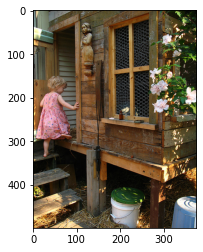

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [15]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [16]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [17]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [18]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [19]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [20]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [21]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [22]:
word_count_threshold = 7
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 2064


In [23]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [24]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [25]:
###GLOVE Embedding
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [26]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [27]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 1s 0us/step


In [29]:
model_new = Model(model.input, model.layers[-2].output)

In [30]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [31]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [32]:
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step


In [33]:
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

1/1 [==============================] - 0s 25ms/step


In [35]:
model=load_model("mymodel2.h5")

In [36]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [37]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [38]:
@anvil.server.callable
def Validation(imagename):
  image = imagename
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images_path+pic)
  plt.imshow(x)
  plt.show()

    #print("Greedy Search:",greedySearch(image))
    #print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
    #print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
    #print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
    #print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))
  prediction_beam = beam_search_predictions(image, beam_index = 10)
  return prediction_beam

In [ ]:
Validation('1772859261_236c09b861.jpg')

In [39]:
@anvil.server.callable
def Greedy(imagename):
  image = imagename
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images_path+pic)
  plt.imshow(x)
  plt.show()

    #print("Greedy Search:",greedySearch(image))
    #print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
    #print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
    #print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
    #print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))
  prediction_greedy = greedySearch(image)
  return prediction_greedy

In [ ]:
Greedy('1772859261_236c09b861.jpg')

In [ ]:
@anvil.server.callable
def ShowImage(imagename):
  pic = imagename
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images_path+pic)
  plt.imshow(x)
  plt.show()

  #return ShowImage

In [ ]:
def ShowImage(imagename):
  image = imagename
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images_path+pic)
  plt.imshow(x)
  plt.show()

In [ ]:
ShowImage('1772859261_236c09b861.jpg')

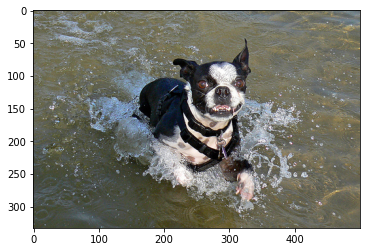

Greedy Search: a black and white dog is running through the water
Beam Search, K = 3: a black and white dog is running through the water
Beam Search, K = 5: a black and white dog is playing with a ball in its mouth
Beam Search, K = 7: a black and white dog plays with a stick in its mouth
Beam Search, K = 10: a black and white dog plays with a stick in its mouth


In [41]:
pic = '1772859261_236c09b861.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

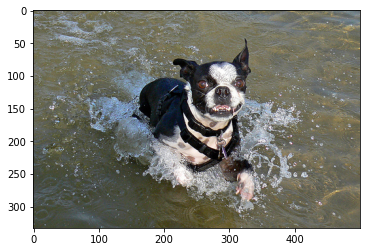

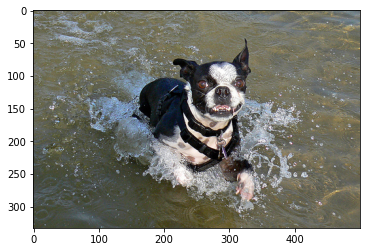

In [ ]:
anvil.server.wait_forever()